# Named Entity Recognition (NER) using LSTM


https://towardsdatascience.com/named-entity-recognition-ner-meeting-industrys-requirement-by-applying-state-of-the-art-deep-698d2b3b4ede

In [3]:
"""
    Reading the raw data: BIO tagged sentences
"""
import pandas as pd
df_raw = pd.read_csv('data.csv')
df_raw.head()

,sentence_idx,sentence,tags
0,1.0,Thousands of demonstrators have marched throug...,O O O O O O B-geo O O O O O B-geo O O O B-gpe ...
1,2.0,Families of soldiers killed in the conflict jo...,O O O O O O O O O O O O O O O O O B-per O O O ...
2,3.0,They marched from the Houses of Parliament to ...,O O O O O O O O O O O B-geo I-geo O
3,4.0,"Police put the number of marchers at 10,000 wh...",O O O O O O O O O O O O O O O
4,5.0,The protest comes on the eve of annual confere...,O O O O O O O O O B-geo O O B-org I-org O O B-...


In [66]:
df_raw['sentence'][0]

'Thousands of demonstrators have marched through London to protest the war in Iraq and demand withdrawal British troops from that country .'

# Distribution of number of words in a sentence

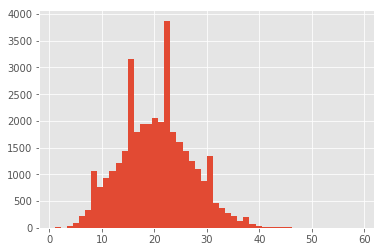

In [10]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
sentences = df_raw['sentence'].tolist()
%matplotlib inline
plt.hist([len(sentence.split()) for sentence in sentences], bins=50)
plt.show()

# Converting the input to the format required by the model

In [11]:
"""
    Functions to transform the data into desired format
"""
max_len = 50
def pad_words(words, pad):
    padded_words = []
    for i in range(max_len):
        try:
            padded_words.append(words[i])
        except:
            padded_words.append(pad)
    return padded_words

import re
def add_tuple(row, tuples):
    sentence_index = "Sentence: {}".format(int(row[0]))
    sentence = row[1]
    re.sub(' ,', ',', sentence)
    re.sub(' .', '.', sentence)
    tag_string = row[2]
    
    words = sentence.split()
    tags = tag_string.split()
    indices = len(words)*[sentence_index]
        
    if len(words) != len(tags):
        # print("len words = {} len tags = {}".format(len(words), len(tags)))
        return []
    
    for (i, w, t) in list(zip(indices, words, tags)):
        tuples.append((i,w,t))
        
    return tuples    
        
tuples = []
df_raw.apply(lambda row: add_tuple(row, tuples), axis=1)
df = pd.DataFrame(tuples, columns=['Sentence #', 'Word', 'Tag'])
df.head()

,Sentence #,Word,Tag
0,Sentence: 1,Thousands,O
1,Sentence: 1,of,O
2,Sentence: 1,demonstrators,O
3,Sentence: 1,have,O
4,Sentence: 1,marched,O


In [64]:
df['Tag'].value_counts()

O        601279
B-geo     26963
B-tim     14823
B-org     14636
I-per     12516
I-org     12221
B-per     12172
B-gpe     11244
I-geo      5316
I-tim      4612
B-art       289
B-eve       232
I-eve       198
I-art       188
B-nat       157
I-gpe       147
I-nat        47
Name: Tag, dtype: int64

# Number of words and tags

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")

data = df
data = data.fillna(method="ffill")

words = set(list(data['Word'].values))
words.add('PADword')
n_words = len(words)
print("Number of words: {}".format(n_words))

tags = list(set(data["Tag"].values))
n_tags = len(tags)
print("Number of tags: {}".format(n_tags))

Number of words: 30164
Number of tags: 17


# Generate tagged sentences

In [13]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [14]:
getter = SentenceGetter(data)
sent = getter.get_next()
print(sent)

[('Thousands', 'O'), ('of', 'O'), ('demonstrators', 'O'), ('have', 'O'), ('marched', 'O'), ('through', 'O'), ('London', 'B-geo'), ('to', 'O'), ('protest', 'O'), ('the', 'O'), ('war', 'O'), ('in', 'O'), ('Iraq', 'B-geo'), ('and', 'O'), ('demand', 'O'), ('withdrawal', 'O'), ('British', 'B-gpe'), ('troops', 'O'), ('from', 'O'), ('that', 'O'), ('country', 'O'), ('.', 'O')]


In [16]:
sentences = getter.sentences
print("Number of sentences: {}".format(len(sentences)))

Number of sentences: 35174


In [18]:
largest_sen = max(len(sen) for sen in sentences)
print("Largest sentence has {} words".format(largest_sen))

Largest sentence has 59 words


# Padding

In [19]:
"""
    Pad the sentences with PADword
"""
max_len = 50
X = [[w[0]for w in s] for s in sentences]
new_X = []
for seq in X:
    new_seq = []
    for i in range(max_len):
        try:
            new_seq.append(seq[i])
        except:
            new_seq.append("PADword")
    new_X.append(new_seq)
new_X[15]

['Israeli',
 'officials',
 'say',
 'Prime',
 'Minister',
 'Ariel',
 'Sharon',
 'will',
 'undergo',
 'a',
 'medical',
 'procedure',
 'Thursday',
 'to',
 'close',
 'tiny',
 'hole',
 'in',
 'his',
 'heart',
 'discovered',
 'during',
 'treatment',
 'for',
 'minor',
 'stroke',
 'suffered',
 'last',
 'month',
 '.',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword']

In [20]:
"""
    Pad the tags
"""
from keras.preprocessing.sequence import pad_sequences

tags2index = {t:i for i,t in enumerate(tags)}
y = [[tags2index[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tags2index["O"])
y[15]

Using TensorFlow backend.


array([ 5, 16, 16,  4,  2,  2,  2, 16, 16, 16, 16, 16, 13, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16],
      dtype=int32)

# Train-test split

In [35]:
from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(new_X, y, test_size=0.1, random_state=42)
print(len(X_tr), len(X_te))

31656 3518


# Import the ELMo embeddings from tfhub

In [26]:
import tensorflow as tf
import tensorflow_hub as hub
from keras import backend as K

sess = tf.Session()
K.set_session(sess)
elmo_model = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)
sess.run(tf.global_variables_initializer())
sess.run(tf.tables_initializer())

In [27]:
"""
    Function to convert sentences to ELMo embeddings
"""
batch_size = 32
def ElmoEmbedding(x):
    return elmo_model(inputs={"tokens": tf.squeeze(tf.cast(x,tf.string)),"sequence_len": tf.constant(batch_size*[max_len])
                     },
                      signature="tokens",
                      as_dict=True)["elmo"]

# Model : Residual Bidirectional LSTM with ELMo Embeddings

In [24]:
from keras.models import Model, Input
from keras.layers.merge import add
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Lambda

input_text = Input(shape=(max_len,), dtype=tf.string)
embedding = Lambda(ElmoEmbedding, output_shape=(max_len, 1024))(input_text)
x = Bidirectional(LSTM(units=512, return_sequences=True,
                       recurrent_dropout=0.2, dropout=0.2))(embedding)
x_rnn = Bidirectional(LSTM(units=512, return_sequences=True,
                           recurrent_dropout=0.2, dropout=0.2))(x)
x = add([x, x_rnn])  # residual connection to the first biLSTM
out = TimeDistributed(Dense(n_tags, activation="softmax"))(x)

model = Model(input_text, out)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


# Training

In [32]:
"""
    Train-validation split
"""
n_batches_train = (8*len(X_tr)//10)//batch_size
n_batches_val = (2*len(X_tr)//10)//batch_size

X_tr, X_val = X_tr[:n_batches_train*batch_size], X_tr[-n_batches_val*batch_size:]
y_tr, y_val = y_tr[:n_batches_train*batch_size], y_tr[-n_batches_val*batch_size:]
y_tr = y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)
y_val = y_val.reshape(y_val.shape[0], y_val.shape[1], 1)

history = model.fit(np.array(X_tr), y_tr, validation_data=(np.array(X_val), y_val),batch_size=batch_size, epochs=3, verbose=1)

Train on 25312 samples, validate on 6304 samples
Epoch 1/3
25312/25312 [==============================] - 553s 22ms/step - loss: 0.0690 - acc: 0.9803 - val_loss: 0.0463 - val_acc: 0.9853
Epoch 2/3
25312/25312 [==============================] - 540s 21ms/step - loss: 0.0426 - acc: 0.9864 - val_loss: 0.0427 - val_acc: 0.9860
Epoch 3/3
25312/25312 [==============================] - 545s 22ms/step - loss: 0.0350 - acc: 0.9884 - val_loss: 0.0414 - val_acc: 0.9865


# Evaluation

In [36]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
n_batches_test = len(X_te)//batch_size
X_te = X_te[:n_batches_test*batch_size]
test_pred = model.predict(np.array(X_te), verbose=1)

3488/3488 [==============================] - 45s 13ms/step


In [37]:
"""
    The precision, recall, and f1-score
"""
idx2tag = {i: w for w, i in tags2index.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PADword", "O"))
        out.append(out_i)
    return out

def test2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            out_i.append(idx2tag[p].replace("PADword", "O"))
        out.append(out_i)
    return out
    
pred_labels = pred2label(test_pred)
test_labels = test2label(y_te[:n_batches_test*32])

print(classification_report(test_labels, pred_labels))

             precision    recall  f1-score   support

        per       0.75      0.78      0.77      1266
        geo       0.82      0.90      0.86      2622
        gpe       0.95      0.93      0.94      1143
        tim       0.89      0.85      0.87      1523
        org       0.69      0.63      0.66      1421
        eve       0.12      0.10      0.11        20
        art       0.33      0.06      0.10        34
        nat       0.67      0.15      0.25        13

avg / total       0.81      0.82      0.82      8042



# Confusion matrix

In [38]:
from sklearn.metrics import confusion_matrix

def flatten(A):
    return [item for sublist in A for item in sublist]

cm = confusion_matrix(flatten(test_labels), flatten(pred_labels))

In [40]:
C = cm
C = np.around(C / C.astype(np.float).sum(axis=0), 2)

/home/raghav/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


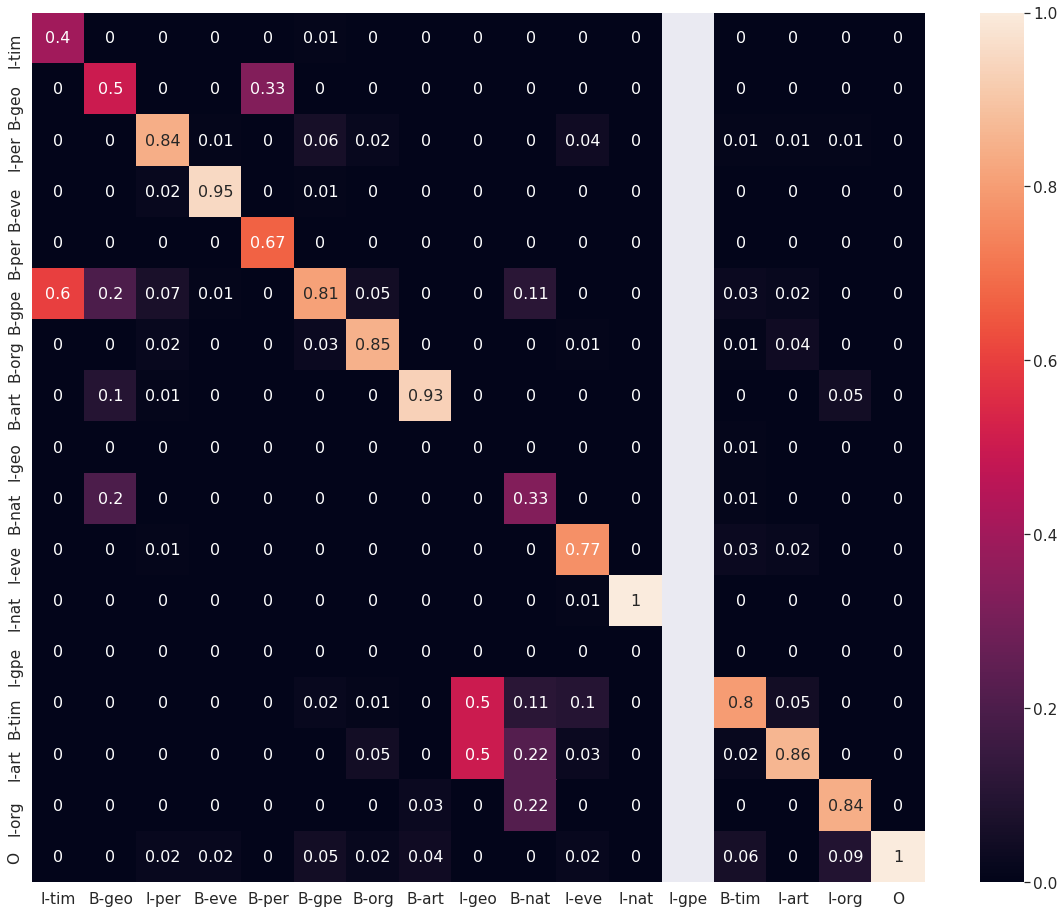

In [63]:
"""
    Horizontal axis: True labels
    Vertical axis: predicted labels
    
    For example: 95% of I-tim lables are correctly predicted as I-tim
    
"""

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

array = C
df_cm = pd.DataFrame(array, tags,
                  tags)
plt.figure(figsize = (20,16))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16})# font size

# Eyeballing

In [104]:
def get_lowercase(batch):
    lowercase_batch = []
    for words in batch:
        lowercase_words = []
        for word in words:
            if not word == 'PADword':
                lowercase_word = word.lower()
            else:
                lowercase_word = word
            lowercase_words.append(lowercase_word)    
        lowercase_batch.append(lowercase_words)    
    return lowercase_batch

def show_sample(i):
    p = model.predict(np.array(X_te[i:i+batch_size]))[0]
    p = np.argmax(p, axis=-1)
    print("{:15} {:5}: ({})".format("Word", "Pred", "True"))
    print("="*30)
    for w, true, pred in zip(X_te[i], y_te[i], p):
        if w != "__PAD__":
            print("{:15}:{:5} ({})".format(w, tags[pred], tags[true]))
    print("\n\n")

def show_sample_lowercase(i):
    lowercase_batch = get_lowercase(X_te[i:i+batch_size])
    p = model.predict(np.array(lowercase_batch))[0]
    p = np.argmax(p, axis=-1)
    print("{:15} {:5}: ({})".format("Word", "Pred", "True"))
    print("="*30)
    for w, true, pred in zip(lowercase_batch[0], y_te[i], p):
        if w != "__PAD__":
                print("{:15}:{:5} ({})".format(w, tags[pred], tags[true]))
    print("\n\n")

In [107]:
from random import randint
num_eyeball_samples = 5
for i in range(num_eyeball_samples):
    i = randint(0, len(X_te)) 
    print("Sample Number: {}".format(i))
    show_sample(i)

Sample Number: 126
Word            Pred : (True)
However        :O     (O)
,              :O     (O)
a              :O     (O)
spokeswoman    :O     (O)
for            :O     (O)
the            :O     (O)
U.N.           :B-org (B-geo)
agency         :O     (O)
Fadela         :B-per (B-per)
Chaib          :I-per (I-per)
said           :O     (O)
Friday         :B-tim (B-tim)
outbreak       :O     (O)
can            :O     (O)
be             :O     (O)
controlled     :O     (O)
if             :O     (O)
people         :O     (O)
suspected      :O     (O)
of             :O     (O)
infection      :O     (O)
are            :O     (O)
put            :O     (O)
in             :O     (O)
isolation      :O     (O)
and            :O     (O)
all            :O     (O)
their          :O     (O)
contacts       :O     (O)
identified     :O     (O)
.              :O     (O)
PADword        :O     (O)
PADword        :O     (O)
PADword        :O     (O)
PADword        :O     (O)
PADword        :O     (O)

In [108]:
"""
    Lowercase test
"""
from random import randint
num_eyeball_samples = 5
for i in range(num_eyeball_samples):
    i = randint(0, len(X_te)) 
    print("Sample Number: {}".format(i))
    show_sample(i)
    show_sample_lowercase(i)

Sample Number: 3134
Word            Pred : (True)
Brazilian      :B-gpe (B-gpe)
leader         :O     (O)
Luiz           :B-per (B-per)
Inacio         :I-per (I-per)
Lula           :I-per (I-per)
da             :I-per (I-per)
Silva          :I-per (I-per)
and            :O     (O)
Evo            :B-per (B-per)
Morales        :I-per (I-per)
of             :O     (O)
Bolivia        :B-geo (B-geo)
met            :O     (O)
Saturday       :B-tim (B-tim)
in             :O     (O)
Vienna         :B-geo (B-geo)
on             :O     (O)
the            :O     (O)
sidelines      :O     (O)
European       :B-org (B-org)
Union-Latin    :I-org (I-org)
America        :I-org (I-org)
summit         :O     (O)
.              :O     (O)
PADword        :O     (O)
PADword        :O     (O)
PADword        :O     (O)
PADword        :O     (O)
PADword        :O     (O)
PADword        :O     (O)
PADword        :O     (O)
PADword        :O     (O)
PADword        :O     (O)
PADword        :O     (O)
PADword   

Word            Pred : (True)
The            :O     (O)
militia        :O     (O)
are            :O     (O)
seen           :O     (O)
as             :O     (O)
a              :O     (O)
root           :O     (O)
cause          :O     (O)
of             :O     (O)
instability    :O     (O)
in             :O     (O)
the            :O     (O)
region         :O     (O)
.              :O     (O)
PADword        :O     (O)
PADword        :O     (O)
PADword        :O     (O)
PADword        :O     (O)
PADword        :O     (O)
PADword        :O     (O)
PADword        :O     (O)
PADword        :O     (O)
PADword        :O     (O)
PADword        :O     (O)
PADword        :O     (O)
PADword        :O     (O)
PADword        :O     (O)
PADword        :O     (O)
PADword        :O     (O)
PADword        :O     (O)
PADword        :O     (O)
PADword        :O     (O)
PADword        :O     (O)
PADword        :O     (O)
PADword        :O     (O)
PADword        :O     (O)
PADword        :O     (O)
PADword 

In [73]:
len(type(X_te[:batch_size])

str

'abc'